<a href="https://colab.research.google.com/github/Anantika0410/Mini-Project/blob/main/test3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install wfdb and compatible pandas
!pip install pandas==2.2.3 wfdb --upgrade --quiet

# Download normal and abnormal ECG files
!wget -q -O 100.dat https://physionet.org/files/mitdb/1.0.0/100.dat?download
!wget -q -O 100.hea https://physionet.org/files/mitdb/1.0.0/100.hea?download

!wget -q -O 105.dat https://physionet.org/files/mitdb/1.0.0/105.dat?download
!wget -q -O 105.hea https://physionet.org/files/mitdb/1.0.0/105.hea?download


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 103.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 13.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [ ]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Load records
record_normal = wfdb.rdrecord('100')
record_abnormal = wfdb.rdrecord('105')

# Take channel 0
signal_normal = record_normal.p_signal[:, 0]
signal_abnormal = record_abnormal.p_signal[:, 0]

# Split into windows
window_size = 140

def split_into_windows(signal, label):
    X, y = [], []
    for i in range(0, len(signal) - window_size, window_size):
        segment = signal[i:i+window_size]
        X.append(segment)
        y.append(label)
    return np.array(X), np.array(y)

X_normal, y_normal = split_into_windows(signal_normal, 0)
X_abnormal, y_abnormal = split_into_windows(signal_abnormal, 1)

# Combine
X = np.concatenate((X_normal, X_abnormal), axis=0)
y = np.concatenate((y_normal, y_abnormal), axis=0)

# Shuffle the data
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

# Reshape for LSTM (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape}, Testing samples: {X_test.shape}")


Training samples: (7427, 140, 1), Testing samples: (1857, 140, 1)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(140, 1)))
model.add(Dropout(0.3))
model.add(LSTM(32))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 140, 64)        │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 140, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_split=0.2)


Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 25s 222ms/step - accuracy: 0.6035 - loss: 0.6697 - val_accuracy: 0.5007 - val_loss: 0.7538
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 35s 155ms/step - accuracy: 0.4825 - loss: 0.7153 - val_accuracy: 0.5121 - val_loss: 0.6923
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 19s 145ms/step - accuracy: 0.4996 - loss: 0.6955 - val_accuracy: 0.5363 - val_loss: 0.6925
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 21s 149ms/step - accuracy: 0.5178 - loss: 0.6923 - val_accuracy: 0.4906 - val_loss: 0.6932
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 0.5060 - loss: 0.6953 - val_accuracy: 0.5074 - val_loss: 0.6909
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step - accuracy: 0.5158 - loss: 0.6924 - val_accuracy: 0.5114 - val_loss: 0.6921
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 19s 140ms/step - accuracy: 0.5094 - loss: 0.6946 - val_accuracy: 0.5114 - val_loss: 0.6925
Epoch 8/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 20s 141ms/step - accuracy: 0.5039 - loss: 0.6939 - val_accu

59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8249 - loss: 0.3660
Test Accuracy: 0.8277


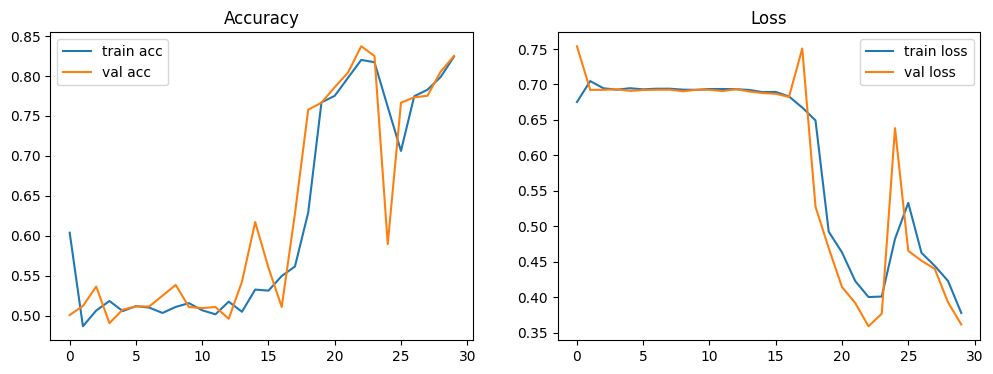

In [ ]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot training history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')
plt.show()



In [ ]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)  # Convert probabilities to binary class labels

# Print the classification report
print(" Classification Report:")
print(classification_report(y_test, y_pred_classes))

59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step
 Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       942
           1       0.88      0.75      0.81       915

    accuracy                           0.83      1857
   macro avg       0.83      0.83      0.83      1857
weighted avg       0.83      0.83      0.83      1857

